# Gait Classification 

In this notebook we are going to achieve the following:

1. **Create the Training Dataset**: We will preprocess and combine data from different sources to create a comprehensive training dataset.
2. **Feature Selection and Dimensionality Reduction**: We will identify the most relevant features for classification using dimensionality reduction techniques.
3. **Model Evaluation**: We will test and compare the performance of multiple machine learning and deep learning algorithms for gait classification.

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from data_preprocessing import merge_all_types
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score


# Constants
healthy_dir = 'Data/Healthy'
stroke_dir = 'Data/Stroke'

In [2]:
# Create the data file combining the results of feature extraction for both healthy and stroke patients
merge_all_types(healthy_dir, stroke_dir)
data = pd.read_csv('final_dataset.csv')


# Drop the column subject_id as we don't need it
data = data.drop(columns=['subject_id'])
data.head()

Saved dataset with shape (14, 58) to final_dataset.csv


,left-z-axis-(deg/s)-mean,left-z-axis-(deg/s)-std,left-z-axis-(deg/s)-max,left-z-axis-(deg/s)-min,left-z-axis-(deg/s)-rms,left-z-axis-(deg/s)-mad,left-z-axis-(deg/s)-range,left-z-axis-(deg/s)-iqr,left-z-axis-(deg/s)-skew,left-z-axis-(deg/s)-kurt,...,stride_duration_symmetry_ratio_std,left_peak_mean,left_peak_std,right_peak_mean,right_peak_std,peak_diff_mean,peak_diff_std,z_corr_mean,z_corr_std,label
0,3.517065,159.709732,441.890,-335.854,159.742786,51.037,777.744,75.54900,0.983153,3.727653,...,0.215819,255.738435,192.021695,241.707494,186.276608,51.220594,98.289195,0.355017,0.598094,0
1,5.582664,110.967208,403.659,-266.768,111.105428,13.841,670.427,46.46300,1.430622,5.716239,...,0.199100,145.117230,172.010967,152.168704,166.921704,62.353264,109.251306,0.355703,0.500949,0
2,-1.558208,119.737293,423.963,-293.171,119.743424,18.232,717.134,48.39975,1.192807,5.407293,...,0.215823,171.334850,181.012320,194.829357,208.993551,37.156625,53.607212,0.430178,0.523371,0
3,1.881431,121.682049,390.549,-314.024,121.694034,35.427,704.573,53.35400,1.261703,4.868585,...,0.164696,170.333325,170.836405,157.977763,159.326704,45.641111,79.686294,0.458434,0.486268,0
4,0.746919,128.397431,427.317,-247.439,128.396801,42.866,674.756,63.23200,1.347390,4.846586,...,0.200439,166.902381,185.688745,183.529052,197.648330,77.646721,136.361102,0.334730,0.561701,0


# Feature Selection and Dimensionality Reduction

## 1. Point-biserial Correlation
The point biserial correlation coefficient is a measure of the correlation between a binary variable (such as a yes/no or pass/fail variable) and a continuous variable. It is similar to the Pearson correlation coefficient, but is used specifically for this type of data. The point biserial correlation coefficient ranges from -1 to 1, with positive values indicating a positive correlation and negative values indicating a negative correlation. Values close to 0 indicate little or no correlation. The p-value represents the probability that the correlation between the two variables is due to chance. Typically, a p-value of less than 0.05 is considered to be statistically significant.

In [3]:
label = data['label']
features = data.drop(columns=['label'])

correlations, p_values = [], []

# Calculate the Point Biserial Correlation Coefficient for each feature
for feature in features:
    correlation, p_value = pointbiserialr(label, features[feature])
    correlations.append(correlation)
    p_values.append(p_value)

# Sort the features by their correlation with the label and create dataframes for better visualization
sorted_indices = np.argsort(correlations)[::-1]
sorted_features = features.columns[sorted_indices]
sorted_correlations = np.array(correlations)[sorted_indices]
sorted_p_values = np.array(p_values)[sorted_indices]

corr_df = pd.DataFrame({'Feature': sorted_features, 'Correlation': sorted_correlations, 'p-value': sorted_p_values})
corr_df.dropna()
corr_df = corr_df[corr_df['p-value'] < 0.05]
corr_df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,Feature,Correlation,p-value
4,left-z-axis-(deg/s)-min,0.912694,5.285328e-06
5,right-z-axis-(deg/s)-min,0.772079,1.213607e-03
31,left-z-axis-(deg/s)-mad,-0.553940,3.984716e-02
32,peak_diff_std,-0.586073,2.762799e-02
33,z_corr_mean,-0.627653,1.625682e-02
34,right-z-axis-(deg/s)-mean,-0.667451,9.105771e-03
35,right-z-axis-(deg/s)-mad,-0.695008,5.796210e-03
36,right_peak_mean,-0.728034,3.155601e-03
37,right-z-axis-(deg/s)-max,-0.794465,6.877625e-04
38,right-z-axis-(deg/s)-pkamp,-0.796033,6.592764e-04


Based on the results here we know that the feature **right-z-axis-(deg/s)-min** has a strong positive correlation of 0.77 and a p-value of 0.001 ensuring that this correlation is not the result of luck. 

---

## 2. Feature Correlation Check though Correlation Matrix


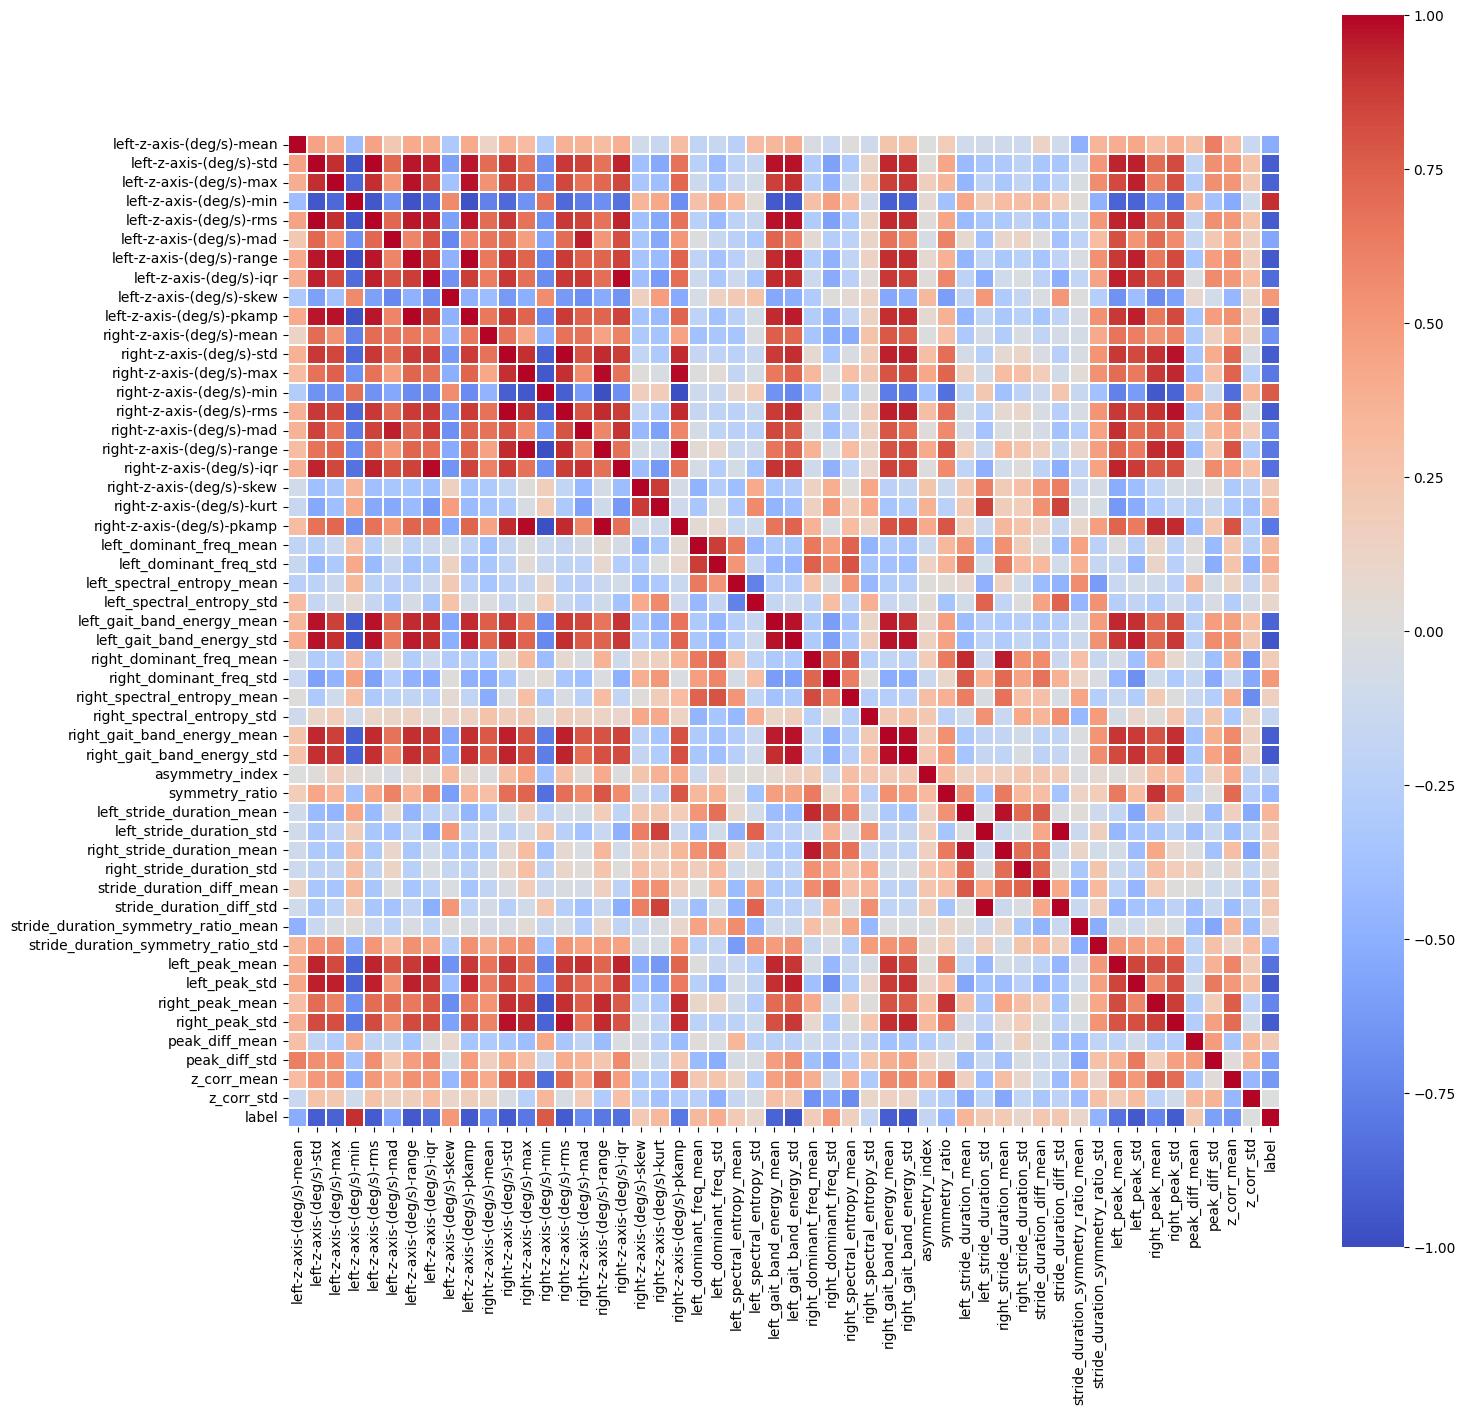

In [4]:
# Create a heatmap of the correlation matrix, excluding the label column that we know have Nan values
columns = ['left-z-axis-(deg/s)-kurt', 'left-z-axis-(deg/s)-zcr', 'right-z-axis-(deg/s)-zcr', 'right-z-axis-(deg/s)-pkcnt', 'left-z-axis-(deg/s)-pkcnt']
data = data.drop(columns=columns)

plt.figure(figsize=(16, 16))
axis_corr = sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', square=True, linewidths=0.1, annot_kws={'fontsize':10})
plt.show()

---

## 3. Principle Component Analysis

The result of PCA gives us a clear separability between the classes of Healthy and Stroke subjects, proving that the two classes can be classified effectively. 
| **Pros of PCA**                  | **Why It’s Useful**                          |
| -------------------------------- | -------------------------------------------- |
| Reveals structure in the data    | Shows healthy vs stroke are separable        |
| Reduces dimensions               | Useful for visualization and fast models     |
| Can improve performance          | Helps in small datasets if too many features |
| Less overfitting risk            | Fewer dimensions = less noise/flexibility    |

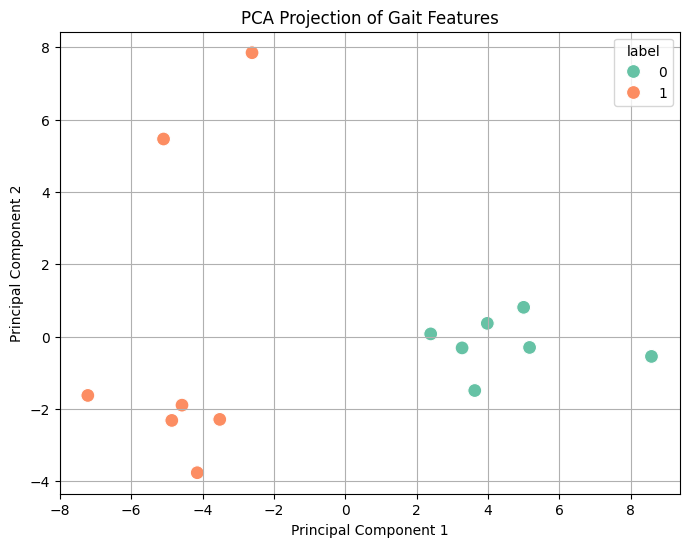

In [5]:

X = data.drop(columns=['label'])
y = data['label']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the PCA projection
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette='Set2', s=100)
plt.title('PCA Projection of Gait Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

One of the main issue with using PCA is that the information is not useful in this contexts. So although PCA easily helps us classify the users, we can not interpret the data and provide insights that doctors can use to help the patients.

| **Cons of PCA (in this use)**        | **Why It’s a Problem**                            |
| -----------------------------------  | ------------------------------------------------- |
| PC1/PC2 are **not interpretable**    | They are weighted sums of 50+ original features   |
| No physical or clinical meaning      | We can’t say PC1 means stride time variability    |
| Clinicians can’t act on it           | They want to know *which* aspect of gait is wrong |
| Feature importance is hidden         | We lose clarity on what the model is using       |

---

## 4. Random Forest and Recursive Feature Elimination  

Recursive Feature Elimination fits a model like Random Forest that starts with all the input variables, then iteratively removes those with the weakest relationship with the output until the desired number of features is reached. It actually fits a model instead of just running statistical tests unlike the Univariate Testing. This is done in order to drop highly correlated features. Given that features X1 and X2 are highly correlated then they will have the same kind of effect on the output variable, where the change in performance observed tends to be negligible. 

The idea here is to reduce the computational complexity and the noise of data while again retaining the meaningful information. 

In [ ]:
# Load dataset
df = pd.read_csv('final_dataset.csv')
X = df.drop(columns=['subject_id', 'label'])
y = df['label']

# Standardize features and Split dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Train RandomForest and get the feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importance_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)

# Recursive Feature Elimination and get feature importance
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)
rfe_df = pd.DataFrame({'feature': X.columns, 'selected_by_rfe': rfe.support_, 'ranking': rfe.ranking_}).sort_values(by='ranking')

# Merge results
merged = pd.merge(importance_df, rfe_df, on='feature', how='inner', validate='one_to_one')
merged.sort_values(by='ranking')

,feature,importance,selected_by_rfe,ranking
0,left-z-axis-(deg/s)-iqr,0.073571,True,1
20,left-z-axis-(deg/s)-min,0.020000,True,1
15,left-z-axis-(deg/s)-rms,0.030000,True,1
12,left_gait_band_energy_mean,0.040000,True,1
11,left-z-axis-(deg/s)-std,0.040000,True,1
6,right-z-axis-(deg/s)-max,0.050000,True,1
13,left-z-axis-(deg/s)-max,0.040000,True,1
1,right_gait_band_energy_mean,0.070000,True,1
5,right_gait_band_energy_std,0.050000,True,1
3,right-z-axis-(deg/s)-range,0.050000,True,1


Based on the feature selection above we found that 11 out of the 58 features provide us the best subset of data to classify between the Healthy and Stroke subjects. The features that provide us the best chance are the following:

| Feature                     | Source                        |
|-----------------------------|-------------------------------|
| right-z-axis-(deg/s)-min    | Point-biserial Correlation    |
| left-z-axis-(deg/s)-iqr     | Recursive Feature Elimination |
| left-z-axis-(deg/s)-min     | Recursive Feature Elimination |
| left-z-axis-(deg/s)-rms     | Recursive Feature Elimination |
| left_gait_band_energy_mean  | Recursive Feature Elimination |
| left-z-axis-(deg/s)-std     | Recursive Feature Elimination |
| right-z-axis-(deg/s)-max    | Recursive Feature Elimination |
| left-z-axis-(deg/s)-max     | Recursive Feature Elimination |
| right_gait_band_energy_mean | Recursive Feature Elimination |
| right_gait_band_energy_std  | Recursive Feature Elimination |
| right-z-axis-(deg/s)-range  | Recursive Feature Elimination |

---

# Machine Learning Model

Given the limited number of data we have to select Machine Learning models in order to get the best possible results. We are going to test a set of machine learning models like:
1. Logistic Regression
2. Random Forest
3. Support Vector Machines

Also we are going to use Leave-One-Out Cross-Validation (LOOCV) for maximum generalization.

In [ ]:
# Reload dataset
df = pd.read_csv('final_dataset.csv')

# Selected top features
selected_features = [
    'right-z-axis-(deg/s)-min',
    'left-z-axis-(deg/s)-iqr',
    'left-z-axis-(deg/s)-min',
    'left-z-axis-(deg/s)-rms',
    'left_gait_band_energy_mean',
    'left-z-axis-(deg/s)-std',
    'right-z-axis-(deg/s)-max',
    'left-z-axis-(deg/s)-max',
    'right_gait_band_energy_mean',
    'right_gait_band_energy_std',
    'right-z-axis-(deg/s)-range'
]

# Feature matrix and labels
X = df[selected_features]
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize LOOCV
cv = LeaveOneOut()

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'Random Forest':       RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear')
}

# Evaluate models using LOOCV
results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv)
    results.append({'model': model_name, 'mean_accuracy': scores.mean(), 'std_accuracy': scores.std(), 'fold_accuracies': scores.tolist()})

# Display the results
results_df = pd.DataFrame(results)
results_df.to_csv('all_features_model_evaluation_results.csv', index=False)
results_df

,model,mean_accuracy,std_accuracy,fold_accuracies
0,Logistic Regression,1.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Random Forest,1.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,SVM (Linear Kernel),1.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## Notes

The result of the training of the models shows that the use of all of these features results at a mean 100% accuracy and 0% standard deviation accuracy. This means that the models over-fit on the data, which would negatively affect the generalizability of the model with unseen or future data. Of course we need to take into consideration that we need to make a model that can be interpreted by medical professionals as well. Based on these criteria we have to choose a subset of features that is helpful to both the patients and the medical staff, with those being: 
1. Right and Left shank maximum swing speed deg/s
2. Right and Left shank minimum swing speed deg/s

In [22]:
# Reload dataset
df = pd.read_csv('final_dataset.csv')

# Selected top features
selected_features = [
    'right-z-axis-(deg/s)-min',
    'left-z-axis-(deg/s)-min',
    'right-z-axis-(deg/s)-max',
    'left-z-axis-(deg/s)-max'
]

# Feature matrix and labels
X = df[selected_features]
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize LOOCV
cv = LeaveOneOut()

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'Random Forest':       RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear')
}

# Evaluate models using LOOCV
results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv)
    results.append({'model': model_name, 'mean_accuracy': scores.mean(), 'std_accuracy': scores.std(), 'fold_accuracies': scores.tolist()})

# Display the results
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results.csv', index=False)
results_df

,model,mean_accuracy,std_accuracy,fold_accuracies
0,Logistic Regression,0.928571,0.257539,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Random Forest,0.928571,0.257539,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,SVM (Linear Kernel),0.928571,0.257539,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
